![設計你的神經網路](images/create_your_NN.png)

我們終於要開始做生命中第一個神經網路...

## 1. 讀入套件

這裡我們讀入一些套件, 今天暫時不要理會細節。

再來是我們標準數據分析動作!

In [2]:
%matplotlib inline
%env KERAS_BACKEND=tensorflow

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt

# 神經網路方面
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# 互動設計用
from ipywidgets import interact_manual

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


## 2. 讀入 MNIST 數據庫

MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的[原始網頁](http://yann.lecun.com/exdb/mnist/)。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

### 2.1 由 Keras 讀入 MNIST

Keras 很貼心的幫我們準備好 MNIST 數據庫, 我們可以這樣讀進來 (第一次要花點時間)。

In [49]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

我們來看看訓練資料是不是 6 萬筆、測試資料是不是有 1 筆。

In [50]:
print(f'訓練資料總筆數為 {len(x_train)} 筆資料')
print(f'測試資料總筆數為 {len(x_test)} 筆資料')

訓練資料總筆數為 60000 筆資料
測試資料總筆數為 10000 筆資料


### 2.2 數據庫的內容

每筆輸入 (x) 就是一個手寫的 0-9 中一個數字的圖檔, 大小為 28x28。而輸出 (y) 當然就是「正確答案」。我們來看看編訓練資料的 x 輸入、輸出的部份分別長什麼樣子。

In [61]:
def show_xy(n=0):
    ax = plt.gca()
    X = x_train[n]
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(X, cmap = 'Greys')
    print(f'本資料 y 給定的答案為: {y_train[n]}')

In [62]:
interact_manual(show_xy, n=(0,59999));

interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

In [63]:
n = 100
X = x_train[n]

In [67]:
X
    

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

### 2.3 輸入格式整理

我們現在要用標準神經網路學學手寫辨識。原來的每筆數據是個 28x28 的矩陣 (array), 但標準神經網路只吃「平平的」, 也就是每次要 28x28=784 長的向量。因此我們要用 `reshape` 調校一下。

In [68]:
x_train.shape

(60000, 28, 28)

In [69]:
x_test.shape

(10000, 28, 28)

In [70]:
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

### 2.4 輸出格式整理

我們可能會想, 我們想學的函數是這樣的型式:

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}$$

其實這樣不太好! 為什麼呢? 比如說我們的輸入 x 是一張 0 的圖, 因為我們訓練的神經網路總會有點誤差, 所以可能會得到:

$$\hat{f}(x) = 0.5$$

那這意思是有可能是 0, 也有可能是 1 嗎!!?? 可是 0 和 1 根本不像啊。換句話說分類的問題這樣做其實不合理!

於是我們會做 "1-hot enconding", 也就是

* 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
* 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0]

等等。因為分類問題基本上都要做這件事, Keras 其實已幫我們準備好套件!

In [71]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

我們來看看剛剛某號數據的答案。

In [73]:
n = 87
y_train[n]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

和我們想的一樣! 至此我們可以打造我們的神經網路了。

## 3. 打造第一個神經網路

我們決定了我們的函數是

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

這個樣子。而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。

### 3.1 決定神經網路架構、讀入相關套件

假如我們要這麼做:

* 使用 <span style="color:red;"> 2 </span> 個 hidden layers
* Hidden layer 1 用 <span style="color:red;"> 50 </span> 個神經元
* Hidden layer 2 用 <span style="color:red;"> 100 </span> 個神經元

* Activation Function 唯一指名 <span style="color:red;">relu</span>

於是從 Keras 把相關套件讀進來。

### 3.2 建構我們的神經網路

和以前做迴歸或機器學習一樣, 我們就打開個「函數學習機」。標準一層一層傳遞的神經網路叫 `Sequential`, 於是我們打開一個空的神經網路。

In [23]:
model = Sequential()

我們每次用 `add` 去加一層, 從第一個隱藏層開始。而第一個隱藏層因為 Keras 當然猜不到輸入有幾個 features, 所以我們要告訴它。

In [24]:
model.add(Dense(50, input_dim=784, activation='relu'))

第二層 hidden layer 因為前面輸出是 4, 現在輸入是 2, 就不用再說了! 這裡的 2 只告訴 Keras, 我們第二層是用 2 個神經元!

In [25]:
model.add(Dense(100, activation='relu'))

輸出有 10 個數字, 所以輸出層的神經元是 10 個! 而如果我們的網路輸出是 

$$(y_1, y_2, \ldots, y_{10})$$

我們還希望

$$\sum_{i=1}^{10} y_i = 1$$

這可能嗎, 結果是很容易, 就用 `softmax` 當激發函數就可以!!

In [26]:
model.add(Dense(10, activation='softmax'))

至此我們的第一個神經網路就建好了!

### 3.3 組裝

和之前比較不一樣的是我們還要做 `compile` 才正式把我們的神經網路建好。你可以發現我們還需要做幾件事:

* 決定使用的 loss function, 一般是 `mse`
* 決定 optimizer, 我們用標準的 SGD
* 設 learning rate

為了一邊訓練一邊看到結果, 我們加設

    metrics=['accuracy']
    
本行基本上和我們的神經網路功能沒有什麼關係。

In [27]:
model.compile(loss='mse', optimizer=SGD(lr=0.001), metrics=['accuracy'])

## 4. 檢視我們的神經網路

我們可以檢視我們神經網路的架構, 可以確認一下是不是和我們想像的一樣。

### 4.1 看 model 的 summary

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 45,360
Trainable params: 45,360
Non-trainable params: 0
_________________________________________________________________


很快算算參數數目和我們想像是否是一樣的!

In [57]:
784*10 + 10

7850

## 5. 訓練你的第一個神經網路

恭喜! 我們完成了第一個神經網路。現在要訓練的時候, 你會發現不是像以前沒頭沒腦把訓練資料送進去就好。這裡我們還有兩件事要決定:

* 一次要訓練幾筆資料 (`batch_size`), 我們就 100 筆調一次參數好了
* 這 6 萬筆資料一共要訓練幾次 (`epochs`), 我們訓練個 20 次試試

於是最精彩的就來了。你要有等待的心理準備...

In [30]:
model.fit(x_train, y_train, batch_size=100, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0890 - acc: 0.2183
Epoch 2/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0889 - acc: 0.2240
Epoch 3/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.0889 - acc: 0.2294
Epoch 4/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.0888 - acc: 0.2345
Epoch 5/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0888 - acc: 0.2395
Epoch 6/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0887 - acc: 0.2447
Epoch 7/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.0887 - acc: 0.2492
Epoch 8/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.0886 - acc: 0.2534
Epoch 9/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0886 - acc: 0.2576
Epoch 10/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.0885 - a

## 6. 試用我們的結果

我們來用比較炫的方式來看看可愛的神經網路學習成果。對指令有問題可以參考我們之前的 MOOC 影片教學。

In [31]:
from ipywidgets import interact_manual

我們 "predict" 放的是我們神經網路的學習結果。這裡用 `predict_classes` 會讓我們 Keras 選 10 個輸出機率最大的那類。

In [32]:
predict = model.predict_classes(x_test)

In [33]:
predict

array([7, 0, 1, ..., 9, 6, 6])

不要忘了我們的 `x_test` 每筆資料已經換成 784 維的向量, 我們要整型回 28x28 的矩陣才能當成圖形顯示出來!

In [34]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

神經網路判斷為: 3


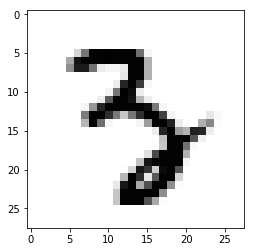

In [35]:
test(87)

In [36]:
interact_manual(test, 測試編號=(0, 9999))

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

<function __main__.test(測試編號)>

到底測試資料總的狀況如何呢? 我們可以給我們神經網路「考一下試」。

In [54]:
score = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 24us/step


In [55]:
print('loss:', score[0])
print('正確率', score[1])

loss: 0.08840728223323822
正確率 0.217


## 7. 訓練好的神經網路存起來!

如果對訓練成果滿意, 我們當然不想每次都再訓練一次! 我們可以把神經網路的架構和訓練好的參數都存起來, 以供日後使用!

之前還沒裝 pyh5 要在終端機 (Anaconda Prompt) 下安裝:
    
    conda install h5py

In [68]:
model_json = model.to_json()
open('stupid_model.json', 'w').write(model_json)
model.save_weights('stupid_model_weights.h5')